# <center>Tutorial on Q-Learning</center>

In [15]:
import codes
import importlib
importlib.reload(codes)

<module 'codes' from '/Users/Jbremy/Documents/reinforcement_toy/codes/__init__.py'>

In [16]:
import copy
import gym
import os

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from codes import utils
from codes.Env import Env
from codes.GridWorld import GridWorld
from codes.LearningRate import LearningRate
from codes.Q import Q
from codes.PolicyEpsilonGreedy import PolicyEpsilonGreedy

from math import radians
import time

# Theoritical introduction

## Markovian Decision Porcess

Before tackling a reinforcement learning problem let's define a modelisation for the agents. The <b>Markovian Decision Process (MDP)</b> is defined as follows:
* A <b>state</b> space $\mathcal{X}$.
* An <b>action</b> space $\mathcal{A}$.
* A <b>transition</b> transition probability distribution $p(x'|x,a)$. This corresponds to the dynamics of the problem. "What is the space when this action is taken while being in this state".
* A <b>reward</b> function $r(x,a)$. "What do we get from performing this action while being in this state".

This modelisation is Markovian since it follows the <b>Markov property</b>:

\begin{equation}
    \mathbb{P}(X_t = x | X_0, \dots, X_{t-1}) = \mathbb{P}(X_t = x | X_{t-1})
\end{equation}

In other words, the evolution of the agent only depends on the state he is in, not on the past. This will be usefull to train the agent.

## The Value function and the Bellman equation

Let's define the <b>Value function</b> $V$ as the total reward we can expect when we are in a certain state. This depends on the <b>policy</b> we choose. The policy $\pi(a|x)$ is defined by the operator, and defines what action is to be taken depending on the state. Then the value function is defined by:

\begin{equation}
    V^\pi(x) = \mathbb{E}\Big[\sum_{t=0}^T \gamma^t r(x_t, a_t) \Big| x_0, \pi \Big]
\end{equation}
Where $\gamma$ is the discount over time and $T$ is the random final time step.

Let's denote by $\pi^*$ the optimal policy, that is to say the policy that maximizes the value function at each state, and by $V^*$ the resulting value function.

If the policy is stationary, meaning that it doesn't change with time, wich is the case for the optimal policy, then the value function follows the <b>Bellman equation</b>:

\begin{equation}
    V^*(x) = r(x,\pi^*(x)) + \gamma \sum_{x' \in \mathcal{X}} p(x'|x,\pi^*(x)) V^*(x')
\end{equation}
Where $\pi^*(x)$ is the action returned by the optimal policy.

## Q-Learning

Instead of trying to learn the value fonction $V(x)$ for all states, Q-learning consists of learning the $Q$ function that associates each couple of state and action with the expected final reward.
The associated value function of a $Q$ function under the policy $\pi$ is:

\begin{equation}
    V^{\pi}(x) = \sum_{a \in \mathcal{A}} \pi(a|x) Q(x, a)
\end{equation}

If we define the optimal policy as the greedy policy $\pi^*(x) = \arg\max_a Q^*(x, a)$. Then the optimal $Q$ function follows the Bellman equation. We can use this to approximate $Q^*$ with the <b>Q-learning</b> algorithm:

<b>Initialize</b> $Q_0$ randomly  
<b>For</b> $e = 1, \dots,n$:  
> <b>Intiate</b> $t = 0, x_0$  
> <b>While</b> $x_t$ <b>not</b> terminal:  
>> <b>Choose</b> $a_t$ according to a suitable <b>exploration policy</b>  
>> <b>Observe</b> $r_t = r(x_t, a_t)$, $x_{t+1}$  
>> <b>Temporal difference</b> $\delta_{t} = r_t$ <b>If</b> $x_t$ is terminal <b>Else</b> $r_t + \gamma \max_{a}Q(x_{t+1}, a) - Q(x_t, a)$  
>> <b>Update</b> $Q(x_t, a_t) =  Q(x_t, a_t) + \alpha(x_t, a_t) \delta_t$  

If the learning rate $\alpha_t$ satisfies the <b>Robbins-Monro</b> conditions $\sum_{t=0}^{\infty} \alpha_t = \infty$ and $\sum_{t=0}^{\infty} \alpha_t^2 < \infty$ for every state action couple, and every state is visited infinitely often then the convergence toward the optimal $Q$ function is guaranted (almost surrely).

# Presentation of the provided Classes

### The first environement we are going to use is a maze:
```python
class  GridWorld(object):
    """A class to generate and interact with a gridworld environement

    Attributes:
        Q (Q): The empirical Q function of the environement.
        V (V): The empirical Value function of the environement.
               !!! Different from Q.V !!!
               Only to use for value iteration
        x, y (int): Coordinates of the agent in the grid.
        t (int): The time stamp in the current run.
        path (list): The path taken during the current run

    Methods:
        reset(self, random_init: bool=False, state: Optional[Tuple[int]]=None)
              -> None:
            Resets the agent to the start/random/required position and time to 0.
        step(self, action: Union[str, int]) 
             -> Tuple[Union[Tuple[int], int, bool, None]]:
            Perfomrs the asked action
        render_path_and_V(self, scale: int=1.5) -> None:
            Plots the path taken by the agent and the Value function.
        render_board(self, scale= float:1.5, show: bool=True,
                     fig: bool=False) -> None:
            displays a figure with the labirynth.
        render_path(self, fig: bool=False, show: bool=True) -> None:
            Plots the path taken by the agent up to now
        render_V(self, fig: bool=False, show: bool=True,from: str='Q') -> None:
            Plots the Value function

    Constants:
        ACTION_SPACE (list): The possible actions in int
        ACTION_DICT (dict): The possible actions in strings
            "up", "right", "down", "left"
    """
```

Note that ```GridWord``` also has an instance of the next ```Q``` class initialized.
### The Q function:
```python
class Q(object):
    """A Q-table for discrete or continous state space

    Attributes:
        W (np.array): The Q table

    Methods:
        __init__(self, actions: List, discrete: bool=True, 
                 state_shape: Optional[Tuple]=None,
                 segmentation: Optional[List]=None, 
                 init_range: List[int]=[0,1]) -> None
            Initialises the Q table.
        __call__(self, observation: Tuple[int], 
                 action: Union[str, int]) -> float:
            Returns the value of the Q table for the state and action provided.
        update(self, value: float, observation: Tuple[int], 
               action: Union[str, int], lr: float) -> None:
            Updates the Q-table value for the oservation-action to the new value
            with provided lr.

    """
```

### The $\epsilon$-Greedy Policy

Earlier we talked about a <b>"suitable exploration ppolicy"</b>. 
The $\epsilon$-greedy policy chooses an action as follows:
* With probability $\epsilon$ returns $\arg\max_a Q(x_t, a)$
* With probability $1-\epsilon$ uniformly chooses <u>another</u> state

```python
class PolicyEpsilonGreedy(object):
    """This is an implementation of the epsilon greedy policy with respect to a
    provided Q-table

    Methods:
        __init__(self, Q: Q, action_space: List[Union[int, str]], 
                 epsilon: float, decay: float, lower: float, 
                 decay_every: int) -> None:
            Initializes the Policy
        __call__(self, state: Union[np.array, List, int, str],
                 be_greedy: bool=False) -> Union[int, str]:
            Returns an action with respect to the policy
```

### Learning-Rate

In Q-learning the learning rate depends on the (state, action) couple. Moreover the  learning rate has to satisfy the Robbins-Monro conditions. Here we are going to use the following learning rate:
* $\alpha(x, a) = \alpha_0 / (1+t(x,a)\beta)$

Where $t(x, a)$ is the number of time this state action couple has been visited.

```python
class LearningRate(object):
    """Implementation of a learning rate with indepandent decay for every
    elements

    Methods:
        __init__(self, lr0: float, decay: float, actions_size: int, 
                     discrete: bool=True, state_shape: Optional[Tuple]=None,
                     segmentation: Optional[List]=None, 
                     min_lr: float=0.1) -> None:
            Initializes the learning rate
        __call__(self, observation: Union[int, np.array], 
                     action: Union[str, int]) -> float:
            Returns the current value of the learning rate for the requiered
            entry in the Q-table
    """
```

# A few theoritical questions

* <b> Why do you think it is important to use the $\epsilon$-greedy policy and not just the greedy policy ?</b>
* <b> Why is the learning rate independant for every (state, action) couple ?</b>
* <b> Why do you think the Robbins-Monro conditions are important ?   

# A toy exemple

Let's consider a simple exemple to illustrate the principles introduces above.

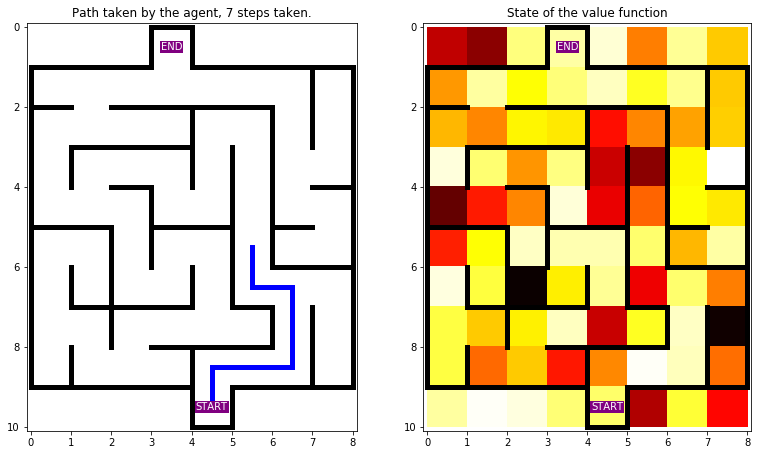

In [17]:
gridworld = GridWorld("../results/GridWorldResults/grid.txt")

for action in ["up", "right", "right", "up", "up", "left", "up"]:
    gridworld.step(action)

gridworld.render_path_and_V()

### Please define this problem as a MDP:

#### Your answer <b>...</b>

## Now we are ready to implement the Q-learning alogrithm

In the next cell you are asked to implement a function that takes as input a ```Q``` instance, an ```env``` and learns the Q function. You only need the ```PolicyEpsilonGreedy``` and ```LearningRate``` classes for that. Please also return the rewards history so that we can plot the learning curve.

In [18]:
def Q_learning(Q_, env, action_space, gamma, print_every_episode, n_episodes, epsilon, epsilon_decay, epsilon_min,
              epsilon_decay_every, lr0, lr_decay, min_lr, max_steps):
    policy = PolicyEpsilonGreedy(Q_, action_space, epsilon, epsilon_decay, epsilon_min,
                                  epsilon_decay_every)
    lr = LearningRate(lr0=lr0, decay=lr_decay, min_lr=min_lr, discrete=Q_._discrete,
                      actions_size=action_space, state_shape=Q_.W.shape[:-1])
    
    # Let's save the rewards of every episode so we can plot the learning curve
    rewards = [0]*n_episodes
    start = time.time()
    print("Starting training\n%i episodes" % (n_episodes))
    for episode in range(n_episodes):
        # Initialisation of the episode
        episode_reward = 0
        state = env.reset()
        for t in range(max_steps):
            action = policy(state)
            res = env.step(action)
            new_state, reward, done = res[:3]
            episode_reward += reward
            if done:  
                Q_.update(reward, state, action, lr(state, action))
                break
                
            else:
                Q_.update(reward +gamma*Q_.get_V(new_state),  state, action, lr(state, action))
                
            state = new_state 
        
        rewards[episode]+=episode_reward
                
        if (episode % print_every_episode == 0 and episode>0) or episode==n_episodes-1:
            print("Finished  episode %i of %i episodes. Mean reward: %.1f" % \
                  (episode, n_episodes, np.mean(rewards[episode-print_every_episode: episode]))\
                 + " (%.2f)" % (time.time()-start))
            
            policy._do_decay()
            
    return Q, policy, rewards

In [19]:
# Initializing the environement
gridworld = GridWorld("../results/GridWorldResults/grid.txt")
action_space = ["up", "right", "down", "left"]

_, policy, rewards = Q_learning(Q_=gridworld.Q, env=gridworld, action_space=action_space,
                                print_every_episode=20, n_episodes=100, gamma=0.9, max_steps=500,
                                epsilon=0.5, epsilon_decay=0.99, epsilon_min=0.4, epsilon_decay_every=50, 
                                lr0=1, lr_decay=0.01, min_lr=0.1)

Starting training
100 episodes
Finished  episode 20 of 100 episodes. Mean reward: 0.8 (0.33)
Finished  episode 40 of 100 episodes. Mean reward: 1.0 (0.42)
Finished  episode 60 of 100 episodes. Mean reward: 1.0 (0.52)
Finished  episode 80 of 100 episodes. Mean reward: 1.0 (0.62)
Finished  episode 99 of 100 episodes. Mean reward: 1.0 (0.70)


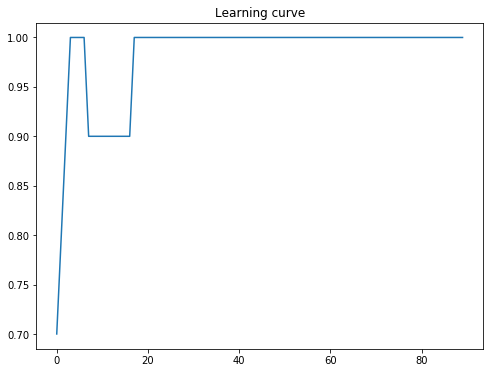

In [20]:
plt.figure(figsize=(8,6))
plt.plot(utils.rolling_average(rewards, 10))
plt.title("Learning curve")
plt.show()

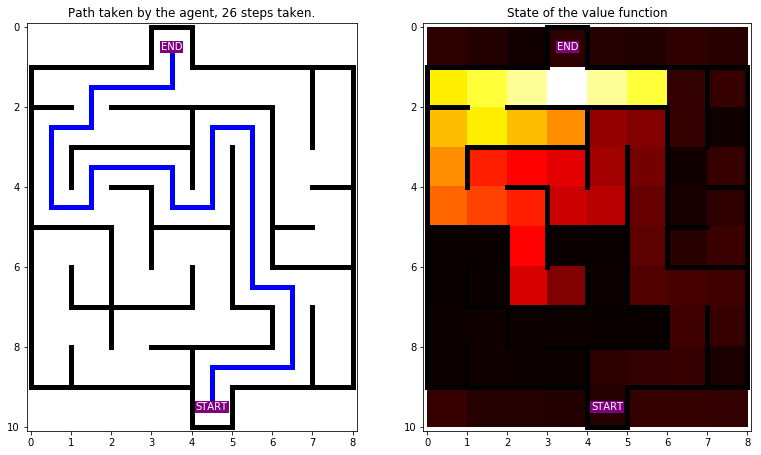

In [21]:
state = gridworld.reset()
done = False
count=0
while not done and count<100:
    count+=1
    action = policy(state, be_greedy=True)
    state, _, done, _ = gridworld.step(action)

gridworld.render_path_and_V()

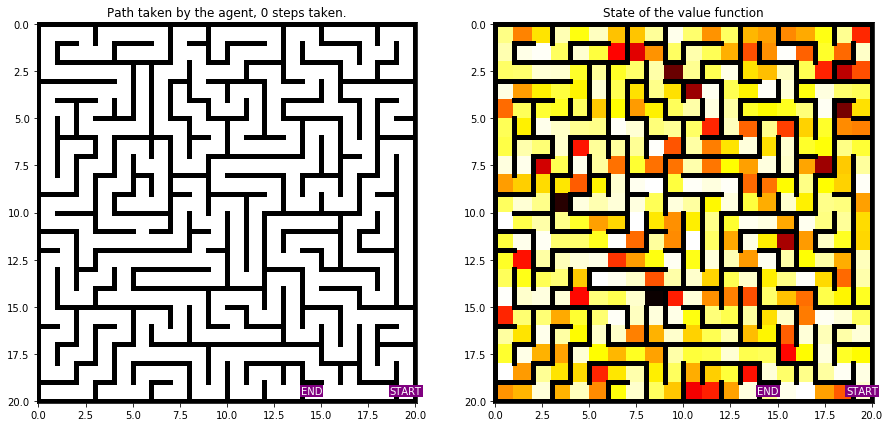

In [22]:
gridworld = GridWorld((20,20))

gridworld.render_path_and_V(0.7)

In [24]:
_, policy, rewards = Q_learning(Q_=gridworld.Q, env=gridworld, action_space=action_space,
                                print_every_episode=20, n_episodes=1000, gamma=0.9, max_steps=500,
                                epsilon=0.5, epsilon_decay=0.99, epsilon_min=0.4, epsilon_decay_every=50, 
                                lr0=1, lr_decay=0.01, min_lr=0.1)

Starting training
1000 episodes
Finished  episode 20 of 1000 episodes. Mean reward: 0.0 (0.79)
Finished  episode 40 of 1000 episodes. Mean reward: 0.1 (1.46)
Finished  episode 60 of 1000 episodes. Mean reward: 0.5 (2.01)
Finished  episode 80 of 1000 episodes. Mean reward: 0.4 (2.57)
Finished  episode 100 of 1000 episodes. Mean reward: 0.8 (2.87)
Finished  episode 120 of 1000 episodes. Mean reward: 0.8 (3.21)
Finished  episode 140 of 1000 episodes. Mean reward: 0.8 (3.54)
Finished  episode 160 of 1000 episodes. Mean reward: 1.0 (3.73)
Finished  episode 180 of 1000 episodes. Mean reward: 1.0 (3.96)
Finished  episode 200 of 1000 episodes. Mean reward: 1.0 (4.19)
Finished  episode 220 of 1000 episodes. Mean reward: 1.0 (4.39)
Finished  episode 240 of 1000 episodes. Mean reward: 1.0 (4.63)
Finished  episode 260 of 1000 episodes. Mean reward: 0.9 (4.87)
Finished  episode 280 of 1000 episodes. Mean reward: 1.0 (5.10)
Finished  episode 300 of 1000 episodes. Mean reward: 1.0 (5.34)
Finished  ep

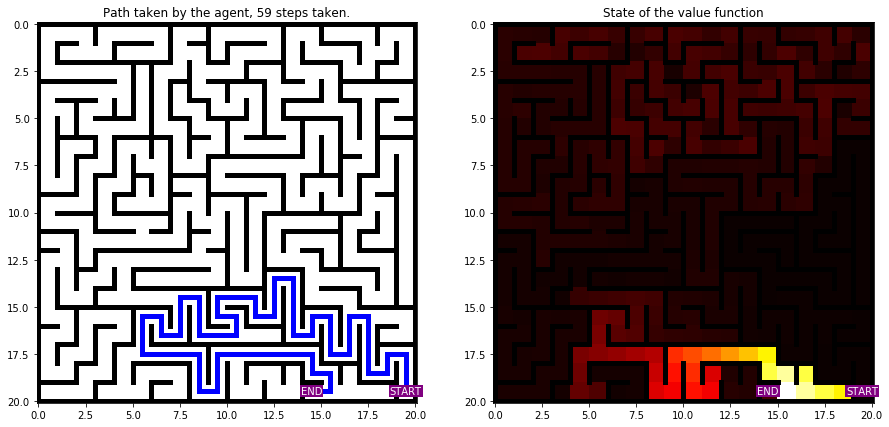

In [25]:
state = gridworld.reset()
done = False
count=0
while not done and count<200:
    count+=1
    action = policy(state, be_greedy=True)
    state, _, done, _ = gridworld.step(action)

gridworld.render_path_and_V(0.7)